# Image segmentation of Cardano NFTs using SingularityNET

The purpose of this notebook is to serve as a guide for setting up the [Image Segmentation service](https://beta.singularitynet.io/servicedetails/org/snet/service/semantic-segmentation) from the SingularityNET AI Marketplace and applying it to an image NFT from the Cardano blockchain.

## 1. Setting up the requirements:

We begin by installing the SingularityNET python SDK and the requests package:

In [ ]:
pip install snet.sdk requests

The next workaround is needed to make the Singularity SDK work in Demeter, since the SDK works for python 3.8 but demeter uses python 3.10:

In [ ]:
def findReplace(filename, find, replace):
    with open(filename, 'r') as file:
        filedata = file.read()
    filedata = filedata.replace(find, replace)
    with open(filename, 'w') as file:
        file.write(filedata)

findReplace("/config/.local/lib/python3.10/site-packages/attrdict/default.py", "from collections import", "from collections.abc import")
findReplace("/config/.local/lib/python3.10/site-packages/attrdict/mapping.py", "from collections import", "from collections.abc import")
findReplace("/config/.local/lib/python3.10/site-packages/attrdict/merge.py", "from collections import", "from collections.abc import")
findReplace("/config/.local/lib/python3.10/site-packages/attrdict/mixins.py", "from collections import", "from collections.abc import")
findReplace("/config/.local/lib/python3.10/site-packages/eth_account/account.py", "from collections import", "from collections.abc import")
findReplace("/config/.local/lib/python3.10/site-packages/rlp/codec.py", "import collections\n", "import collections.abc as collections\n")
findReplace("/config/.local/lib/python3.10/site-packages/rlp/lazy.py", "from collections import", "from collections.abc import")
findReplace("/config/.local/lib/python3.10/site-packages/rlp/sedes/lists.py", "from collections import", "from collections.abc import")
findReplace("/config/.local/lib/python3.10/site-packages/rlp/sedes/raw.py", "from collections import", "from collections.abc import")
findReplace("/config/.local/lib/python3.10/site-packages/rlp/sedes/serializable.py", "import collections\n", "import collections\nimport collections.abc\n")
findReplace("/config/.local/lib/python3.10/site-packages/rlp/sedes/serializable.py", "collections.Sequence", "collections.abc.Sequence")
findReplace("/config/.local/lib/python3.10/site-packages/web3/datastructures.py", "from collections import (\n    Hashable,\n    Mapping,\n    MutableMapping,\n    OrderedDict,\n    Sequence,\n)", "from collections.abc import (\n    Hashable,\n    Mapping,\n    MutableMapping,\n    Sequence,\n)\nfrom collections import OrderedDict")
findReplace("/config/.local/lib/python3.10/site-packages/web3/utils/six/six.py", "import collections\n", "import collections.abc as collections\n")
findReplace("/config/.local/lib/python3.10/site-packages/web3/utils/formatters.py", "from collections import", "from collections.abc import")

Finally, we import these libraries for displaying images and dealing with http requests:

In [ ]:
from IPython.display import Image
import requests

## 2. Obtaining the NFT image from the Cardano blockchain:

First of all, we need the asset of the NFT image we are interested in. You can find many at the [jpg store](https://www.jpg.store/).

In [3]:
# REPLACE WITH YOUR NFT'S ASSET ID
assetID = "dac355946b4317530d9ec0cb142c63a4b624610786c2a32137d78e2561646170654477656e6e6f6e4d617273"

Now we are going to query the asset in the blockchain, and extract the ipfs protocol CID needed to fetch the image.

In [18]:
url = "https://cardano-mainnet.blockfrost.io/api/v0/assets/{}".format(assetID)
response = requests.get(url, headers={"project_id":"mainnet2j439B1srJJ8rEPAQRQyrWtMTEV5fgGl"})

data = response.json()
ipfs_url = data['onchain_metadata']['image']
ipfs_cid = ipfs_url.removeprefix('ipfs://')

Finally we download the image and write it to a file:

In [7]:
image_res = requests.get("https://ipfs.io/ipfs/{}".format(ipfs_cid))

with open("image.jpg", "wb") as f:
    f.write(image_res.content)

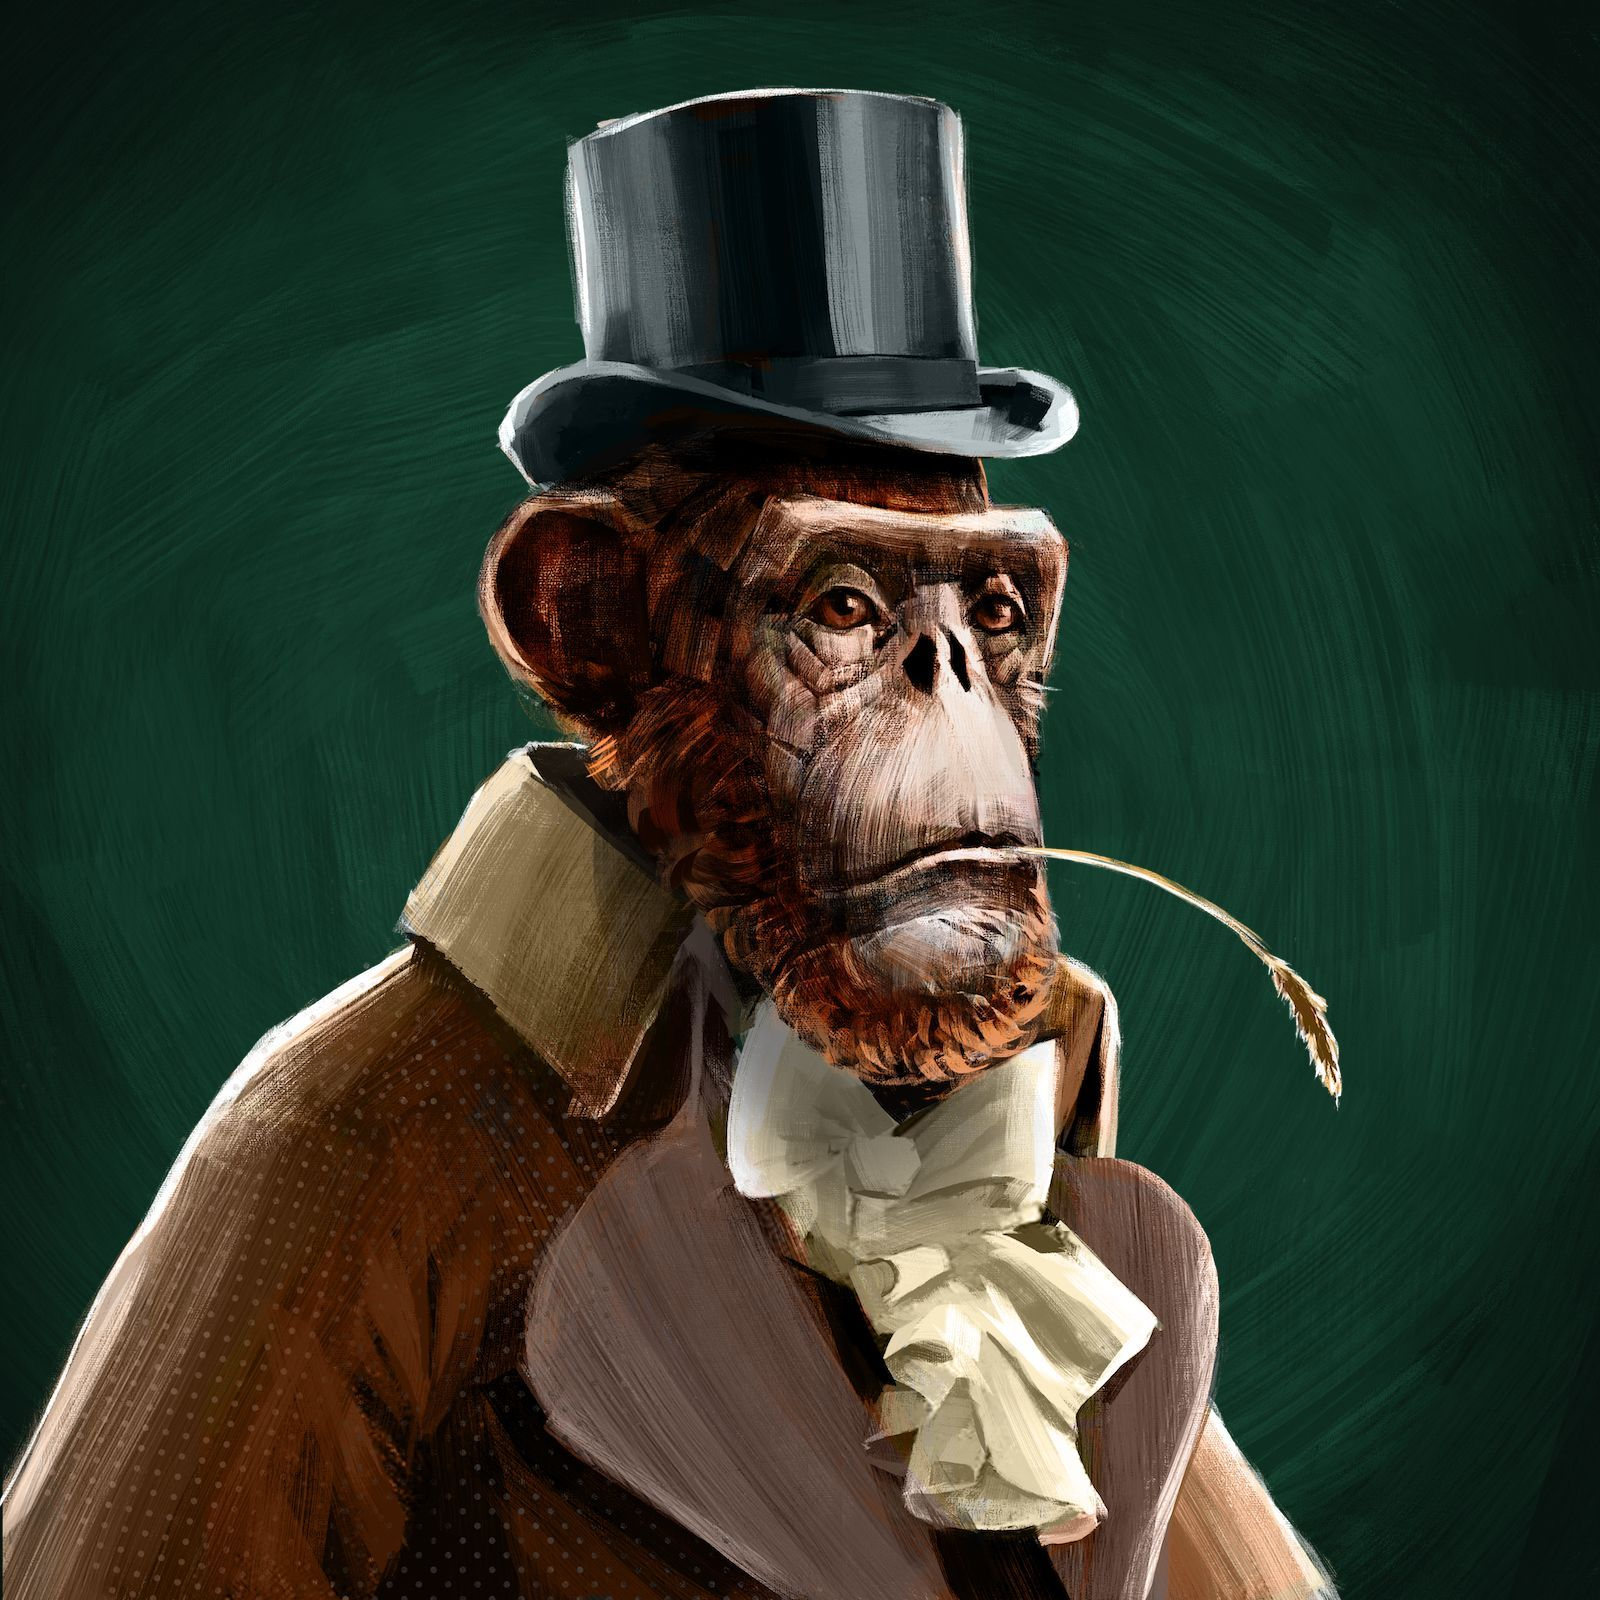

In [13]:
# Display the image:
Image(filename="image.jpg", width="500")

## 3. Invoking the Image Sergmentation service from the Singularity AI Marketplace:

Before running the service, we have to fill the missing fields in `config.py` (inside the `semantic-segmentation` directory) with our Ethereum wallet's private key and our Infura key. You can create an Infura account [here](https://www.infura.io/). Remember to activate the Ethereum mainnet endpoint for your api key.

The first time you run the service, Singularity provides you with some free calls. To generate the Free Call Authentication Token, go to the [Image Segmentation service webpage](https://beta.singularitynet.io/servicedetails/org/snet/service/semantic-segmentation), log in, click on the "Install and Run" tab, scroll down and you will find the api that provides you with the token by pasting your Ethereum public address. Once you download the token file, copy it's values into the corresponding fields of `config.py`.

Now we are ready to run the service!

In [ ]:
%run semantic-segmentation/config.py
%run -i semantic-segmentation/service.py

The response from the service is now in the global variable `response`:

In [11]:
service_response = response

For each entity identified in the image, it's class name and a unique ID is stored:

In [18]:
print("Class names identified: ", service_response.class_names)
print("Class ids identified: ", service_response.class_ids)

Class names identified:  ['person']
Class ids identified:  [1]


The "segmentation image" contains the areas of the image that correspond to identified entities:

In [12]:
segmentation_img = service_response.segmentation_img[0].content
with open("segmentation_img.png", "wb") as f:
    f.write(segmentation_img)

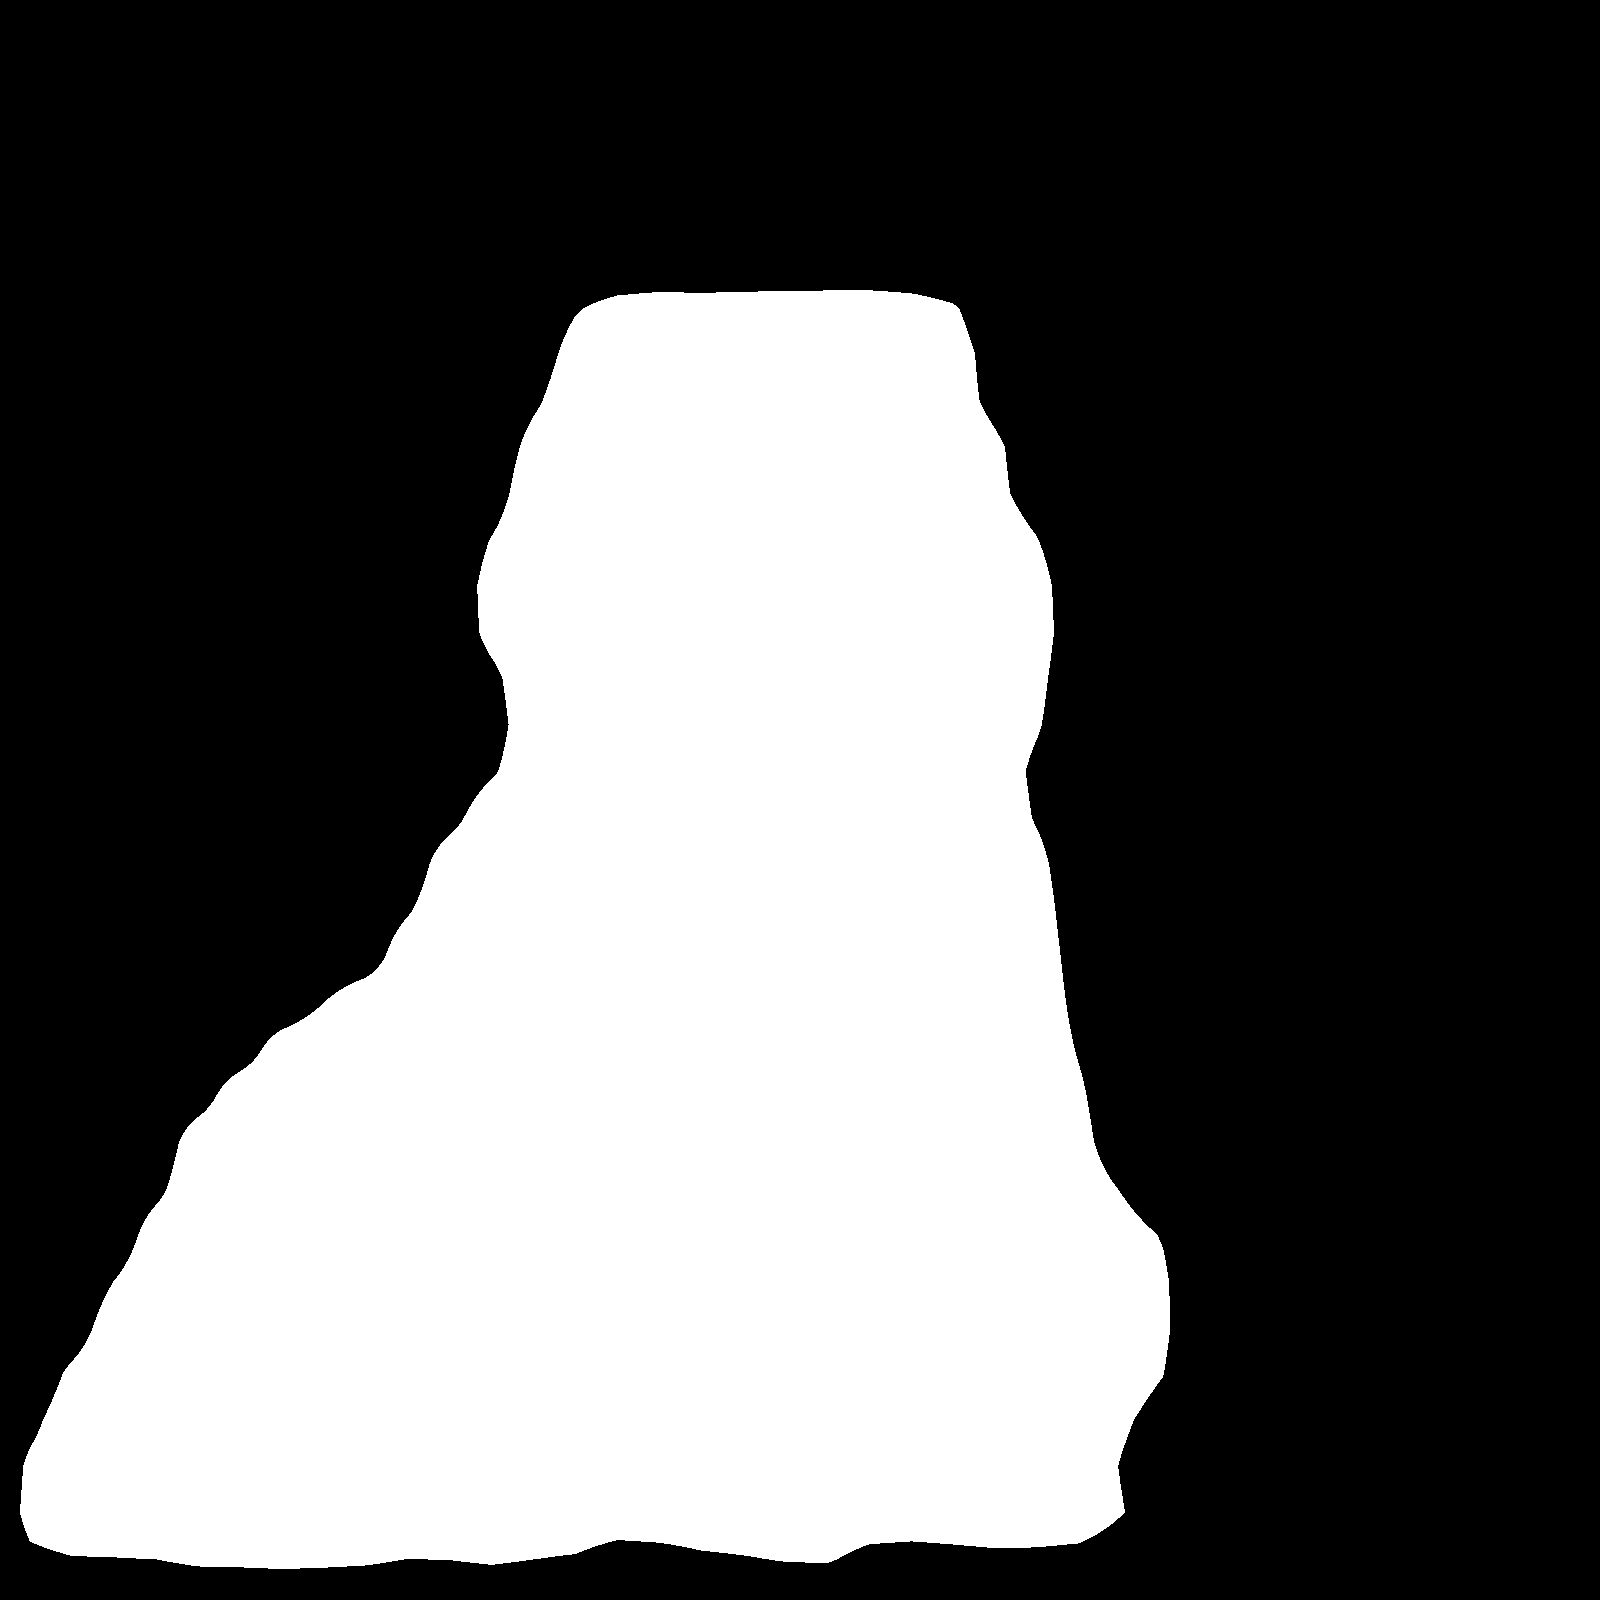

In [4]:
Image(filename="segmentation_img.png", width="500")

Finally, the "debug image" shows a superposition of the original image with the segmentation image, along with the class name of each entity:

In [14]:
debug_img = service_response.debug_img.content
with open("debug_img.png", "wb") as f:
    f.write(debug_img)

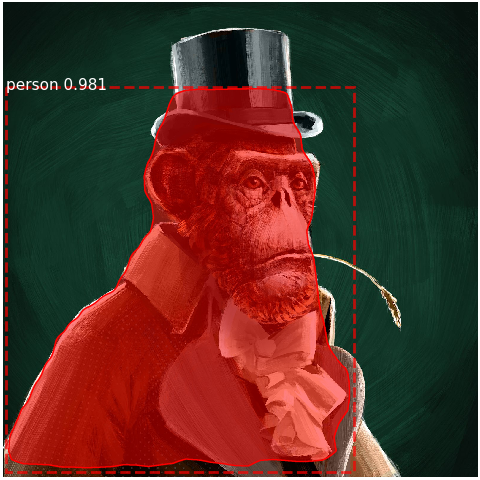

In [15]:
Image(filename="debug_img.png")